Animate binary picture as a line that is been drawn in a gif

1. Analyze Picture
    reduce number of pixels with a set of corresponding coarse pixels
    determine the relation of the coarse pixels to each other
    categorize groups of coarse pixels in lines and points
    (structure with direction and structure without preferred direction)
    reduce unnecessary lines and points
    convert all lines into functional forms
    divide into connected sets
    
2. Find Path through structure
    for each connected set, assemble the functionals of the lines
    with minimal change in the derivatives    
    Allow double drawing of lines
    Optimize evolutionary

3. Animate the path

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import shelve
import networkx as nx
from scipy.sparse import lil_matrix
from scipy.sparse import find
import matplotlib
#matplotlib.use("Agg")
from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib.animation import PillowWriter
import copy
import time
#sys.path.append('/home/mi/robertsk/sideproject/py27/lib/python2.7/site-packages')
#sys.path.append('/home/mi/robertsk/sideproject/py27/local/lib/python2.7/site-packages')

In [134]:
def preppipes2(pipes,pipec,newnh):
    pipeweight=np.zeros([len(pipes),3])
    pipec2=np.zeros([len(pipes),4],dtype=int)
    for i in range(len(pipes)):
        indizes=np.where(newnh[:,4]==(i+1)*2)[0]
        pipeweight[i,2]=np.sum(newnh[indizes,2])
        pipeweight[i,0]=np.sum(newnh[indizes,0]*newnh[indizes,2])/pipeweight[i,2]
        pipeweight[i,1]=np.sum(newnh[indizes,1]*newnh[indizes,2])/pipeweight[i,2]
        
        if newnh[pipec[i][0],4] <0:
            pipec2[i,0]=int((-newnh[pipec[i][0],4]) -1)
            pipec2[i,1]=-1
        else:
            pipec2[i,0]=int((newnh[pipec[i][0],4]-1)/2)
            pipec2[i,1]=1
            
        if newnh[pipec[i][1],4] <0:
            pipec2[i,2]=int((-newnh[pipec[i][1],4]) -1) 
            pipec2[i,3]=-1
        else:
            pipec2[i,2]=int((newnh[pipec[i][1],4]-1)/2)
            pipec2[i,3]=1
            
    return pipeweight,pipec2

def mergesmallpipecrossings(pipes,pipec,crdic,realends,newnh,pipeweight,nei):#newspc,nhl
    mer=[]
    merle=[]
    delet=[]
    newnei=copy.deepcopy(nei)
    ncrdic={}
    for i in range(len(crdic)):
        ncrdic[i]=[i]

    endic={}
    for i in range(len(realends)):
        endic[i]=[i+len(crdic)]
    mempipe={}
    delet=[]
    for i in range(len(pipec)):
        if pipec[i][0]==pipec[i][1]:
            index=pipec[i][0]
            a=pipeweight[i,2]
            b=newnh[index][2]

            if b/2-a>0:#np.sqrt(b)-a >0:
                mer.append(i)
                delet.extend(pipes[i])
                merle.append(index)

    
    umerle=np.unique(merle)
    for i in range(len(umerle)):
        mempipe[umerle[i]]=[]
                
    for i in range(len(mer)):
        newnh[merle[i],3]=newnh[merle[i],3]-2
        weight=pipeweight[mer[i]][2]
        newnh[merle[i],:2]=(newnh[merle[i],:2]*newnh[merle[i],2]+pipeweight[mer[i]][:2]*weight)/(weight+newnh[merle[i],2])
        newnh[merle[i],2]+=weight
        mempipe[merle[i]].extend(pipes[mer[i]])

                
    endiccount=0
    for i in range(len(umerle)):
        if newnh[umerle[i],3]==0:
            del ncrdic[umerle[i]]
            delet.extend(crdic[umerle[i]])
            newnei[umerle[i]]=[]
            #for j in nei[umerle[i]]:
            #    newnei[j]=list(set(newnei[j])-set([umerle[i]]))
        elif newnh[umerle[i],3]==1:
            del ncrdic[umerle[i]]
            endic[len(realends)+endiccount]=crdic[umerle[i]]
            endic[len(realends)+endiccount].extend(mempipe[umerle[i]])
            newnei[umerle[i]]=list(set(nei[umerle[i]])-set(endic[len(realends)+endiccount]))
            endiccount+=1
        elif newnh[umerle[i],3]==2:
            ncrdic[umerle[i]].extend(mempipe[umerle[i]])
            newnei[umerle[i]]=list(set(nei[umerle[i]])-set(ncrdic[umerle[i]]))
            del ncrdic[umerle[i]]
        else:
            ncrdic[umerle[i]].extend(mempipe[umerle[i]])
            newnei[umerle[i]]=list(set(nei[umerle[i]])-set(ncrdic[umerle[i]]))
    
    mask=np.ones(len(newnh),dtype=bool)
    mask[delet]=False
    return newnh,ncrdic,newnei,endic,mask                   

#def pipeneigh()

                   
def neighbourlistd(newcrossings,crndic,newallp,pset,cset,rset,realends,g):
    allpl=newallp[:,0]
    offset=len(realends)+len(crndic)
    neighbourlist=[]
    
    allplind={}
    for i in range(len(newallp)):
        allplind[newallp[i,0]]=i+offset

    for i in range(len(crndic)):
        neighbourlist.append([])
        for j in crndic[i]:
            if j in pset:
                neighbourlist[-1].append(allplind[j])
        
    for i in range(len(realends)):
        neighbourlist.append([])
        for j in nx.neighbors(g,realends[i,0]):
            if j in pset:
                neighbourlist[-1].append(allplind[j])    

        
    for i in range(len(allpl)):
        neighbourlist.append([])
        for j in nx.neighbors(g,allpl[i]):
            if j in pset:
                neighbourlist[-1].append(allplind[j])
            elif j in cset:
                ind=np.where(newcrossings[:,0]==j)[0]
                neighbourlist[-1].extend(newcrossings[ind,1])
            else: #j in rset
                neighbourlist[-1].extend(np.where(realends[:,0]==j)[0]+len(crndic))
                
    return neighbourlist,allplind


def prepallp(allp,nhl):
    pset=set(allp)
    cnhl=np.cumsum(nhl)
    newallp=np.zeros([len(allp),2],dtype=int)
    newallp[:,0]=allp
    for i in range(len(allp)):
        for j in range(len(cnhl)):
            if allp[i]<cnhl[j]:
                k=j
                break
        newallp[i,1]=k    

    return pset,newallp

def newh(newcrossings,newends,newallp,flatnh,newspc,nhl,bimgls):
    a=bimgls
    realends=newends[newends[:,1]==1][:,[0,2]]
    endind=np.cumsum(np.abs(newends[:,1]-1))
    rset=set(realends[:,0])
    allpl=newallp[:,0]#np.array(list(allp))
    size=len(realends)+len(crdic)+len(allpl)
    newnhdic={}
    newcrdic={}
    
    #for i in range(len(new))
    cnhl=np.cumsum([0]+nhl)
    newnh=np.zeros([size,5])
    
    for i in range(np.max(newcrossings[:,1])+1):
        div=0
        newpos=0
        li=np.where(newcrossings[:,1]==i)[0]

        overlap=set()
        for j in li:
            for k in range(len(cnhl)):
                if newcrossings[j,0]<cnhl[k]:
                    m=k-1
                    break
            overlap.update(newspc[m][newcrossings[j,0]-cnhl[m]])
            lev=newcrossings[j,2]+1
            newpos+=flatnh[newcrossings[j,0]]*lev
            div+=lev
        newnh[i,:2]=newpos/np.double(div)
        newnhdic[i]=overlap
        newcrdic[i]=[i]
        newnh[i,2]=len(overlap)
        
    newnh[len(crdic):len(crdic)+len(realends),:2]=flatnh[realends[:,0],:]
    newnh[len(crdic):len(crdic)+len(realends),2]=(realends[:,1]+1)**2
    newnh[len(crdic)+len(realends):,:2]=flatnh[allpl,:]
    newnh[len(crdic)+len(realends):,2]=(newallp[:,1]+1)**2
    
    offs=len(crdic)
    for i in range(offs,len(crdic)+len(realends)):
        inde=realends[i-offs,0]
        for j in range(len(cnhl)):
            if inde <cnhl[j]:
                m=j-1
                break
        newnhdic[i]=set(newspc[m][inde-cnhl[m]])
    offs=len(crdic)+len(realends)
    for i in range(offs,len(newnh)):
        inde=allpl[i-offs]
        for j in range(len(cnhl)):
            if inde <cnhl[j]:
                m=j-1
                break
        newnhdic[i]=set(newspc[m][inde-cnhl[m]])
    
    return newnh,realends,rset,endind[newends[:,1]==1],newnhdic,newcrdic


def prep(flatnhc,g):
    neighbourlist=[]
    for i in range(len(flatnhc)):
        neighbourlist.append([])
        for j in nx.neighbors(g,i):
            neighbourlist[i].append(j)

    edgenumber=np.zeros(len(flatnhc))
    for i in range(len(flatnhc)):
        edgenumber[i]=len(neighbourlist[i])
   
    alln=np.arange(len(edgenumber))
    allp=alln[edgenumber==2]
    singles=alln[edgenumber==0]
    ends=alln[edgenumber==1]
    crossings=alln[edgenumber>2]
    return allp,ends,singles,crossings

def merge(crdic,crndic,newcrossings,cset,newends,eset):
    newcrndic=copy.deepcopy(crndic)
    newcrdic=copy.deepcopy(crdic)
    eset2=copy.deepcopy(eset)
    cset2=copy.deepcopy(cset)
    mem1=[]
    mem2=[]
    mem3=[]
    indi=np.ones(len(newends),dtype=bool)
    for i in range(len(crndic)):
        for j in range(len(crndic[i])):
            if crndic[i][j] in eset:
                point=crndic[i][j]
                newcrdic[i].append(point)
                newcrndic[i].remove(point)
                inde=np.where(newends[:,0]==point)
                mem2.append(point)
                mem1.append(i)
                mem3.append(inde)
                indi[inde]=False
                eset2.discard(point)
                cset2.add(point)
                
    newe=newends[indi]
    newcr2=np.zeros([len(mem1),3],dtype=int)
    for i in range(len(mem1)):
        newcr2[i,0]=mem2[i]
        newcr2[i,1]=mem1[i]
        newcr2[i,2]=newends[mem3[i],2]
        
    newcr=np.concatenate((newcrossings,newcr2),axis=0)
    
    return newcrdic,newcrndic,newcr,cset2,newe,eset2

def makepipe(allp,neighbourlist):
    allp2=copy.deepcopy(allp)
    pipes={}
    pi=0
    pipec=[]
    neighbourlist2=copy.deepcopy(neighbourlist)
    startlen=len(allp2)
    new=np.zeros(2)
    while 0< len(allp2):
        start=allp2.pop()
        nbs=neighbourlist2[start]
        startl=np.copy(start)
        startr=np.copy(start)
        pipes[pi]=[start]
        newl=nbs[1]
        newr=nbs[0]
        newlbs=neighbourlist2[newl]
        newrbs=neighbourlist2[newr]
        while len(newlbs)==2:
            pipes[pi].append(newl)
            allp2.discard(newl)
            newlbs.remove(startl)
            startl=newl
            newl=newlbs[0]
            newlbs=neighbourlist2[newl]

        while len(newrbs)==2:
            pipes[pi].append(newr)
            allp2.discard(newr)
            newrbs.remove(startr)
            startr=newr
            newr=newrbs[0]
            newrbs=neighbourlist2[newr]
        pipec.append((newl,newr))
        pi+=1
    return pipes,pipec

def prepcrossings(crossings,nhl):

    cset=set(crossings)
    cnhl=np.cumsum(nhl)
    newcrossings=np.zeros([len(crossings),3],dtype=int)

    count=0
    cset2=copy.deepcopy(cset)
    crdic={}
    crndic={}
    while 0<len(cset2):
        start=cset2.pop()
        crdic[count]=[]
        crndic[count]=[]
        crdic[count].append(start)
        allnei=set([j for j in g.neighbors(start)])
        n=set([j for j in g.neighbors(start) if j in cset2])
        crndic[count].extend(allnei-cset)#n)
        while 0< len(cset2.intersection(n)):
            nei=n.pop()
            crdic[count].append(nei)
            cset2.discard(nei)
            allnei=set([j for j in g.neighbors(nei)])
            neinei=set([j for j in g.neighbors(nei) if j in cset2])
            crndic[count].extend(allnei-cset)#neinei-set(crndic[count]))
            n=n.union(neinei)
        count+=1
        
    clcr=np.cumsum([0]+[len(crdic[i]) for i in crdic])
    for i in range(len(crdic)):
        for j in range(len(crdic[i])):
            for k in range(len(cnhl)):
                if crdic[i][j]<cnhl[k]:
                    m=k
                    break
            newcrossings[clcr[i]+j,0]=crdic[i][j]
            newcrossings[clcr[i]+j,1]=i
            newcrossings[clcr[i]+j,2]=m        

    return  cset,newcrossings,crdic,crndic

def prepends(ends,nhl):
    cnhl=np.cumsum(nhl)
    eset=set(ends)
    
    newends=np.zeros([len(ends),3],dtype=int)
    newends[:,0]=ends
    for i in range(len(ends)):
        n=[j for j in g.neighbors(ends[i])][0]
        if n in eset:
            newends[i,1]=0
        else:
            newends[i,1]=1
        for j in range(len(cnhl)):
            if ends[i]<cnhl[j]:
                k=j
                break
        newends[i,2]=k

    return eset,newends
        
def prepsingles(singles,nhl):
    sset=set(singles)
    cnhl=np.cumsum(nhl)
    newsing=np.zeros([len(singles),2],dtype=int)
    newsing[:,0]=singles
    for i in range(len(singles)):
        for j in range(len(cnhl)):
            if singles[i]<cnhl[j]:
                k=j
                break
        newsing[i,1]=k    

    return sset,newsing

def preppipes(pipes,newnh,newnhdic):
    pipeweight=np.zeros([len(pipes),3])
    for i in range(len(pipes)):
        div=0
        newpos=0
        li=pipes[i]

        overlap=set()
        for j in li:
            m=int(np.sqrt(newnh[j,2])-1)
            overlap.update(newnhdic[j])
            lev=newnh[j,2]
            newpos+=newnh[j,:2]*lev
            div+=lev
        pipeweight[i,:2]=newpos/np.double(div)
        
        pipeweight[i,2]=len(overlap)
    
    return pipeweight

def reduceconnectivity(g,flatnh):
    for i in range(len(flatnh)):
        nei=[li for li in g.neighbors(i)]
        j=0
        while j<len(nei):
        #[item for item in cn if item in nei]
            cn=set(li2 for li2 in nx.common_neighbors(g,i,nei[j]))
            for k in cn.intersection(nei):
                a=np.sum((flatnh[i]-flatnh[k])**2)
                b=np.sum((flatnh[i]-flatnh[nei[j]])**2)
                c=np.sum((flatnh[nei[j]]-flatnh[k])**2)
                if a>b and a>c:
                    g.remove_edge(i,k)
                    nei.remove(k) 
                elif b>a and b>c:
                    g.remove_edge(nei[j],i)
                    break
                elif c>a and c>b:
                    g.remove_edge(nei[j],k)
            j+=1

def graphandnodes(flatnhc,bimgls,nh,nc,ups):
    S = lil_matrix((len(flatnhc), len(flatnhc)), dtype=int)

    nhl=[]
    for i in range(len(nh)):
        nhl.append(len(nh[i]))

    a=bimgls
    flatnh=np.zeros([len(flatnhc),2])
    counter=0
    for i in range(len(nc)):
        for j in range(len(nc[i])):
            for k in range(len(nc[i][j])):
                for l in range(len(ups[nc[i][j][k]])):
                    hier=ups[nc[i][j][k]][l][0]
                    nei=np.sum(nhl[:hier])+ ups[nc[i][j][k]][l][1]
                    S[np.sum(nhl[:i])+j,nei]=1

            flatnh[counter,:]=nh[i][j]
            counter+=1
    g=nx.Graph(S)   
    return g,flatnh,nhl

def frameneighbours(bimgls,newsp,nh,nc):
    #flatten all hierachies
    a=bimgls
    flatnhc=[]
    newspc=[]
    spcdic={}
    count=0
    for i in range(len(newsp)):
        newspc.append([])
        for j in range(len(newsp[i])):
            
            newspc[i].append([])
            newspc[i][j].append(newsp[i][j][0]*a+newsp[i][j][1])
            newspc[i][j]=newspc[i][j][0]
            
            for k in newspc[i][j]:
                if k in spcdic:
                    spcdic[k].append((i,j))
                else:
                    spcdic[k]=[(i,j)]
            flatnhc.append(nh[i][j][0]*a+nh[i][j][1])
    flatunc=np.unique([ii for subsubl 
                    in [i for subl in nc for i in subl] 
                    for ii in subsubl])

    for i in range(len(newspc)):
        newspc[i]=np.array(newspc[i],dtype=int)
        
    ups={}
    for i in range(len(flatunc)):
        ups[flatunc[i]]=spcdic[flatunc[i]]
    return ups,flatnhc,newspc

def neighbours(nh,bimg):
    a=bimg.shape[0]
    nc=[]
    for i in range(len(nh)):
        nc.append([])
        ones=np.ones(i+1,dtype=int)
        running=np.arange(2*(i+1),dtype=int)%(i+1)
        for j in range(len(nh[i])):
            nc[i].append([])
            xx=running+int(nh[i][j][0]-0.5*i)
            x0=ones*int(nh[i][j][0]-0.5*i-1)
            x1=ones*int(nh[i][j][0]+0.5*i+1)
            yy=running+int(nh[i][j][1]-0.5*i)
            y0=ones*int(nh[i][j][1]-0.5*i-1)
            y1=ones*int(nh[i][j][1]+0.5*i+1)
            x=np.concatenate((xx,x0,x1))
            y=np.concatenate((y0,y1,yy))
            positiv=(x>=0)*(y>=0)*(x<bimg.shape[0])*(y<bimg.shape[1])
            x=x[positiv]
            y=y[positiv]
            nonzero=bimg[x,y]==1
            c=x*a+y
            nc[i][j].append(c[nonzero])
            nc[i][j]=nc[i][j][0]
    return nc

def quadratic_hierachy(bimg,level=5):
    bimg0=np.zeros(np.array(bimg.shape)+2*level)
    bimg0[level:-level,level:-level]=bimg
    points0=np.array(np.where(bimg0==1))
    points=np.copy(points0)
    spirals0=np.zeros([3,len(points0[0,:])])
    hierachy=[]
    pointlabel=np.arange(len(points[0,:]))
    result=[pointlabel]
    a=bimg0.shape[0]
    spiralmem=[points0[0,:]*a+points0[1,:]]
    for i in range(level):
        steps=3+2*i
        spirals=np.zeros([steps,len(points[0,:])])
        spiralmems=np.zeros([steps,len(points[0,:])],dtype=np.int64)
        for j in range(steps):
            if i%2==0:
                if j==0:
                    points[0,:]=points[0,:]-1
                    spirals[j]=bimg0[points[0,:],points[1,:]]
                    spiralmems[j]=points[0,:]*a+points[1,:]
                elif j<(i+2):
                    points[1,:]=points[1,:]-1
                    spirals[j]=bimg0[points[0,:],points[1,:]]
                    spiralmems[j]=points[0,:]*a+points[1,:]
                else:
                    points[0,:]=points[0,:]+1
                    spirals[j]=bimg0[points[0,:],points[1,:]]
                    spiralmems[j]=points[0,:]*a+points[1,:]
            else:
                if j==0:
                    points[0,:]=points[0,:]+1
                    spirals[j]=bimg0[points[0,:],points[1,:]]
                    spiralmems[j]=points[0,:]*a+points[1,:]
                elif j<(i+2):
                    points[1,:]=points[1,:]+1
                    spirals[j]=bimg0[points[0,:],points[1,:]]
                    spiralmems[j]=points[0,:]*a+points[1,:]
                else:
                    points[0,:]=points[0,:]-1
                    spirals[j]=bimg0[points[0,:],points[1,:]]
                    spiralmems[j]=points[0,:]*a+points[1,:]
                    
        check=np.sum(spirals,axis=0)==steps
        points=points[:,check]
        pointlabel=pointlabel[check]
        print(np.sum(check))
        spiralmem.append(spiralmems[:,check])
        result.append(pointlabel)
        hierachy.append(np.setdiff1d(result[i],result[i+1]))
    hierachy.append(result[-1])
    
    fullspiral=[]
    for j in range(len(spiralmem[0])):
            fullspiral.append([spiralmem[0][j]])
    for i in range(1,level): 
        for j in range(len(spiralmem[i][0,:])):
            if len(result[i])==0:
                pass
            else:
                fullspiral[result[i][j]].extend(spiralmem[i][:,j].tolist())
    sh=[]
    nh=[]
    retspiral=[]
    for i in range(len(hierachy)):
        sh.append([fullspiral[j] for j in hierachy[i]])
        nh.append([])
        retspiral.append([])
    for i in range(level):
        search=[]

        for j in range(i,level):
            search.extend(sh[j+1]) 
        sear=set(np.unique([item for sublist in search for item in sublist]))
        for j in range(len(hierachy[i])):
            if len(set(fullspiral[hierachy[i][j]])-sear)!=0:
                nh[i].append(points0[:,hierachy[i][j]].tolist())
                retspiral[i].append(fullspiral[hierachy[i][j]])
    for i in range(len(nh)):
        if i%2==0:
            nh[i]=np.array(nh[i])-level
        else:
            nh[i]=np.array(nh[i])-level-0.5

    newsp=[]
    for i in range(len(retspiral)):
        newsp.append([])
        temp=np.zeros([2,(i+1)**2])
        for j in range(len(retspiral[i])):
            temp[0,:]=np.array(np.array(retspiral[i][j])/a,dtype=np.int64)
            temp[1,:]=np.array(retspiral[i][j])-temp[0,:]*a
            #temp[0,:]=np.array(np.array(retspiral[i][j])%a,dtype=np.int64)
            #temp[1,:]=np.array(retspiral[i][j])//a

            temp=temp-level
            newsp[i].append(temp.astype(np.int64))
            
    return nh,newsp

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [ ]:
#import numba
#from numba import jit

filename='variables.out'
my_shelf = shelve.open(filename)
for key in my_shelf:
    globals()[key]=my_shelf[key]
my_shelf.close()


In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

gray = rgb2gray(img)    

plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

122789
37180
14518
5934
2460
939
348
94
21
2
0
0
0
0
0
0
number_of_nodes
2759
number_of_edges
4069
number_of_selfloops
387
longest connected set
2445
number of connected sets with length 1,2,3 ...
206
54
0
0
0


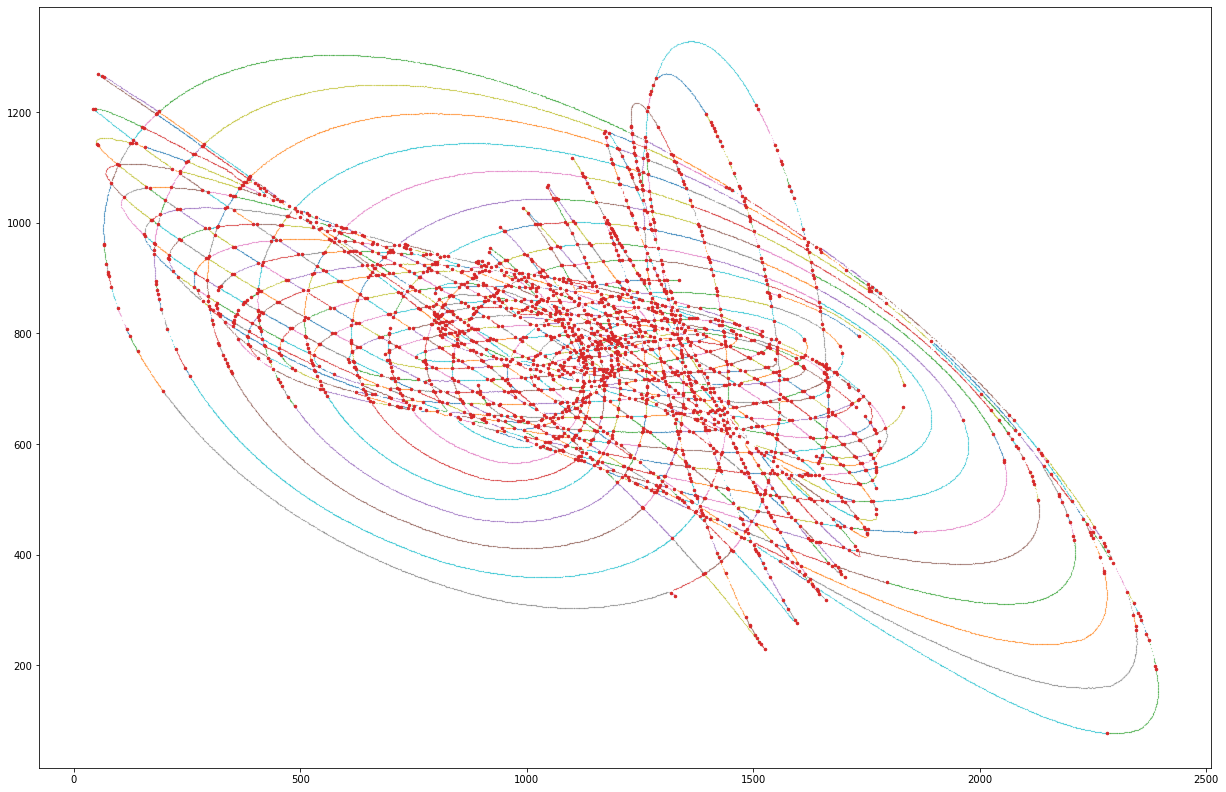

In [177]:
img = mpimg.imread('test2.png') 
gray = rgb2gray(img) 
if gray.shape[1]>gray.shape[0]:
    gray=gray.T
threshold=0.6
bimg=np.copy(gray)
bimg[gray<threshold]=1
bimg[gray>=threshold]=0
bimgls=bimg.shape[0]
time0=[]
timeline=[]
time0.append(time.time())
nh,newsp=quadratic_hierachy(bimg,level=16)
timeline.append('quad_hierach')
time0.append(time.time())
nc=neighbours(nh,bimg)
timeline.append('construct border of spirals')
time0.append(time.time())
ups,flatnhc,newspc=frameneighbours(bimgls,newsp,nh,nc)
timeline.append('correspondence of border pixels to spirals')
time0.append(time.time())
g,flatnh,nhl=graphandnodes(flatnhc,bimgls,nh,nc,ups)
timeline.append('flatten hierachies and produce graph')
time0.append(time.time())
reduceconnectivity(g,flatnh)
timeline.append('eraze all triangles')
time0.append(time.time())
allp,ends,singles,crossings=prep(flatnhc,g)
timeline.append('first categorization of points')
time0.append(time.time())
pset,newallp=prepallp(allp,nhl)
timeline.append('prepare possiblepipes')
time0.append(time.time())
eset,newends=prepends(ends,nhl)
timeline.append('prepare possible ends')
cset,newcrossings,crdic,crndic=prepcrossings(crossings,nhl)
timeline.append('prepare and merge crossings')
time0.append(time.time())
#sset,newsing=prepsingles(singles,nhl)
#timeline.append('prepare singles')
#time0.append(time.time())

crdic,crndic,newcrossings,cset,newends,eset=merge(
    crdic,crndic,newcrossings,cset,newends,eset)
number_of_crossings=len(crdic)

timeline.append('merge crossing-end connections')
time0.append(time.time())
newnh,realends,rset,endind,newnhdic,crdic=newh(newcrossings,newends,newallp,flatnh,newspc,nhl,bimgls)
timeline.append('construct new coordinates and ends')
time0.append(time.time())
nei,allplind=neighbourlistd(newcrossings,crndic,newallp,pset,cset,rset,realends,g)

timeline.append('neighourlist')
time0.append(time.time())

edgenumber=np.zeros(len(newnh))
for i in range(len(newnh)):
    edgenumber[i]=len(nei[i])

newnh[:,3]=edgenumber
alln=np.arange(len(newnh))
pp=set(alln[edgenumber==2])
cc=set(alln[edgenumber>2])
rr=set(alln[edgenumber==1])


timeline.append('second categorization of points')
time0.append(time.time())
pipes,pipec=makepipe(pp,nei)
timeline.append('merge pipes')
time0.append(time.time())
pipeweight=preppipes(pipes,newnh,newnhdic)
timeline.append('prepare newpipes')
time0.append(time.time())

newnh,ncrdic,nei,endic,mask=mergesmallpipecrossings(pipes,
                        pipec,crdic,realends,newnh,pipeweight,nei)


newnh[:,4]=0
nccount=0
for i in ncrdic:
    newnh[ncrdic[i],4]=2*nccount+1
    nccount+=1

        
for i in range(len(newnh)):
    edgenumber[i]=len(nei[i])

alln=np.arange(len(newnh))[mask]
pp=set(alln[edgenumber[mask]==2])


pipes,pipec=makepipe(pp,nei)

for i in pipes:
    for j in pipes[i]:
        newnh[j,4]=(i+1)*2

for i in endic:
    for j in endic[i]: 
        newnh[j,4]=-(i+1)
        
pipeweight,pipec=preppipes2(pipes,pipec,newnh)
timeline.append('further reduction')
time0.append(time.time())

newg=nx.Graph()
newg.add_nodes_from(np.arange(len(ncrdic)+len(endic)))
newpipec=np.zeros([len(pipec),2])
for i in range(len(newpipec)):
    if pipec[i,1]==1:
        newpipec[i,0]=pipec[i,0]
    else:
        newpipec[i,0]=pipec[i,0]+len(ncrdic)
    
    if pipec[i,3]==1:
        newpipec[i,1]=pipec[i,2]
    else:
        newpipec[i,1]=pipec[i,2]+len(ncrdic)

pipelen=np.sum([len(pipes[i]) for i in pipes])
newnewnh=np.zeros([len(ncrdic)+len(endic)+len(pipes),5])
newnewnhdic={}
count=0
for i in ncrdic:
    index=0
    newnewnhdic[count]=newnhdic[ncrdic[i][index]]
    for j in range(1,len(ncrdic[i])):
        newnewnhdic[count]=newnewnhdic[count].union(newnhdic[ncrdic[i][index]])
        if newnh[ncrdic[i][j],2]>newnh[ncrdic[i][index],2]:
            index=j
    newnewnh[count]=newnh[ncrdic[i][index]]
    
    
    count+=1
for i in endic:
    index=0
    newnewnhdic[count]=newnhdic[endic[i][index]]
    for j in range(1,len(endic[i])):
        newnewnhdic[count]=newnewnhdic[count].union(newnhdic[endic[i][index]])
        if newnh[endic[i][j],2]>newnh[endic[i][index],2]:
            index=j
    newnewnh[count]=newnh[endic[i][index]]
    count+=1
for i in pipes:
    newnewnh[count,:3]=pipeweight[i]
    newnewnh[count,3:]=newnh[pipes[i][0],3:]
    newnewnhdic[count]=newnhdic[pipes[i][0]]
    for j in range(1,len(pipes[i])):
        newnewnhdic[count]=newnewnhdic[count].union(newnhdic[pipes[i][j]])
    count+=1
    
newg.add_edges_from(newpipec)

tf=nx.adjacency_matrix(newg)
tr=tf.todense()
con=nx.connected_components(newg)
conn=[]
for i in con:
    conn.append(i)

conlens=[]
for i in range(len(conn)):
    conlens.append(len(conn[i]))
conlens=np.array(conlens)
print('number_of_nodes')
print(newg.number_of_nodes())
print('number_of_edges')
print(newg.number_of_edges())
print('number_of_selfloops')
print(newg.number_of_selfloops())
print('longest connected set')
print(np.max(conlens))
longconset=conn[np.where(conlens==np.max(conlens))[0][0]]
print('number of connected sets with length 1,2,3 ...')
print(len(np.where(conlens==1)[0]))
print(len(np.where(conlens==2)[0]))
print(len(np.where(conlens==3)[0]))
print(len(np.where(conlens==4)[0]))
print(len(np.where(conlens==5)[0]))

timeline.append('make new graph')
time0.append(time.time())
time0=np.diff(np.array(time0))


longcon=np.array(list(longconset),dtype=int)
locopi={}
for i in pipes:
    if newpipec[i,0] in longconset and newpipec[i,1] in longconset:
        locopi[i]=pipes[i]
fig, ax = plt.subplots(figsize=(21,14))
for i in locopi:
    plt.plot(newnh[locopi[i],0],newnh[locopi[i],1],'.',markersize=0.3)
plt.plot(newnewnh[longcon,0],newnewnh[longcon,1],'.',markersize=5)

Point 3 flatten hierachies and produce graph
22.036259174346924


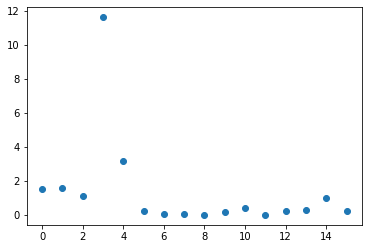

In [171]:
plt.plot(time0,'o')
print('Point 3 '+timeline[3])
print(np.sum(time0))

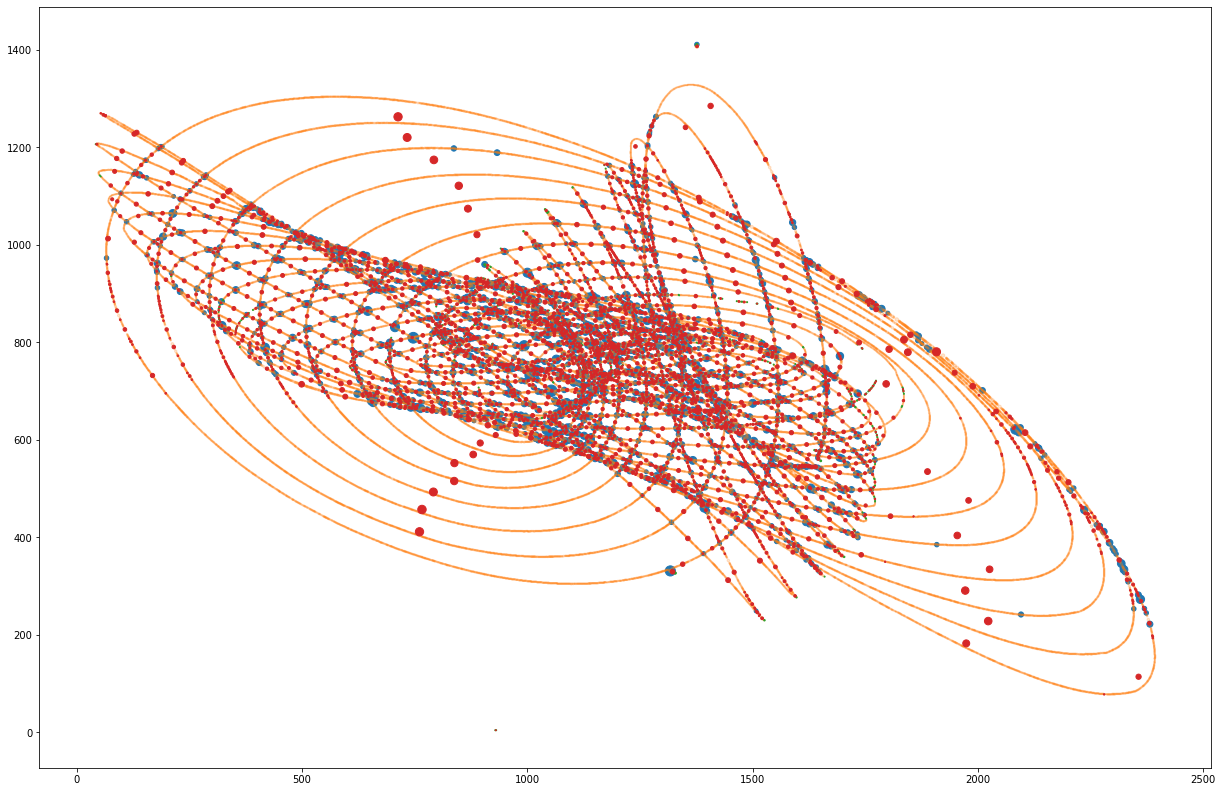

In [126]:
fig, ax = plt.subplots(figsize=(21,14))
scat=ax.scatter(newnh[:,0][newnh[:,3]>2],
         newnh[:,1][newnh[:,3]>2])
scat2=ax.scatter(newnh2[:,0][newnh2[:,3]==2],
         newnh2[:,1][newnh2[:,3]==2],alpha=0.2)
scat3=ax.scatter(newnh2[:,0][newnh2[:,3]==1],
         newnh2[:,1][newnh2[:,3]==1])
scat4=ax.scatter(pipeweight2[:,0],
         pipeweight2[:,1])
scat4.set_sizes(np.sqrt(pipeweight2[:,2]))
scat3.set_sizes(np.sqrt(newnh2[:,2][newnh2[:,3]==1]))
scat2.set_sizes(np.sqrt(newnh2[:,2][newnh2[:,3]==2]))
scat.set_sizes(np.sqrt(newnh2[:,2][newnh2[:,3]>2])*5)

In [151]:
newnh2=newnh
co=np.array(list(conn[1]),dtype=int)


In [152]:
np.max(pipec)

2334

In [157]:
conn[1]

{1,
 3.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 16.0,
 17.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 28.0,
 30.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 41.0,
 42.0,
 43.0,
 45.0,
 46.0,
 47.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 60.0,
 61.0,
 64.0,
 66.0,
 68.0,
 69.0,
 72.0,
 73.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 83.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 119.0,
 120.0,
 121.0,
 123.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 129.0,
 130.0,
 131.0,
 132.0,
 133.0,
 134.0,
 135.0,
 136.0,
 137.0,
 138.0,
 139.0,
 140.0,
 141.0,
 143.0,
 144.0,
 145.0,
 146.0,
 147.0,
 148.0,
 149.0,
 150.0,
 151.0,
 153.0,
 154.0,
 155.0,
 156.0,
 158.0,
 159.0,
 160.0,
 161.0,
 163.0,
 164.0,
 165.0,
 167.0,
 168

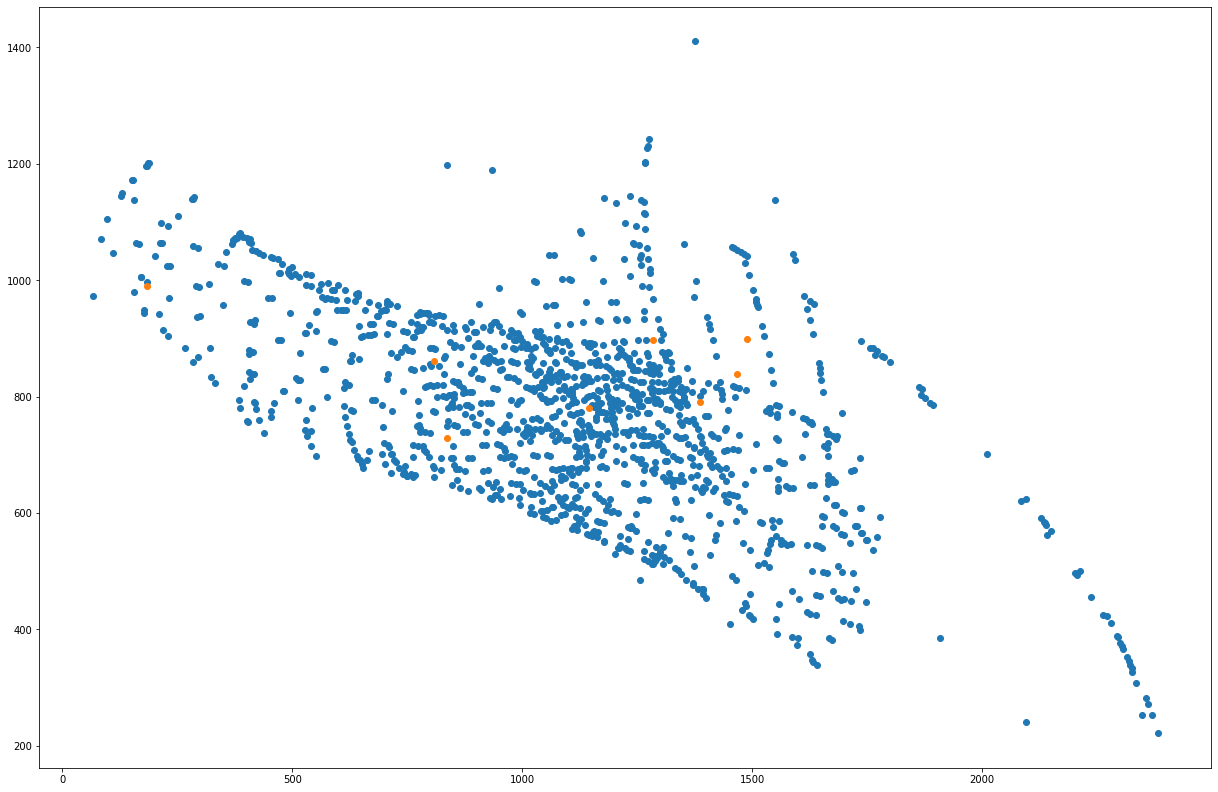

In [158]:
co=np.array(list(conn[1]),dtype=int)
fig, ax = plt.subplots(figsize=(21,14))
scat=ax.scatter(newnh[co,0][newnh[co,3]>2],
         newnh[co,1][newnh[co,3]>2])
#scat2=ax.scatter(newnh2[co,0][newnh2[co,3]==2],
#         newnh2[co,1][newnh2[co,3]==2],alpha=0.2)
scat3=ax.scatter(newnh2[co,0][newnh2[co,3]==1],
         newnh2[co,1][newnh2[co,3]==1])
#scat4=ax.scatter(pipeweight2[co,0],
#         pipeweight2[co,1])
#scat4.set_sizes(np.sqrt(pipeweight2[co,2]))
#scat3.set_sizes(np.sqrt(newnh2[co,2][newnh2[co,3]==1]))
scat2.set_sizes(np.sqrt(newnh2[co,2][newnh2[co,3]==2]))
#scat.set_sizes(np.sqrt(newnh2[co,2][newnh2[co,3]>2])*5)

In [128]:
co

[0,
 1.0,
 3.0,
 5.0,
 7.0,
 9.0,
 11.0,
 13.0,
 15.0,
 17.0,
 19.0,
 21.0,
 23.0,
 25.0,
 27.0,
 29.0,
 31.0,
 33.0,
 35.0,
 39.0,
 41.0,
 43.0,
 45.0,
 47.0,
 49.0,
 51.0,
 53.0,
 55.0,
 57.0,
 59.0,
 61.0,
 65.0,
 67.0,
 69.0,
 71.0,
 73.0,
 75.0,
 77.0,
 79.0,
 81.0,
 83.0,
 85.0,
 87.0,
 89.0,
 91.0,
 93.0,
 95.0,
 99.0,
 101.0,
 103.0,
 105.0,
 107.0,
 109.0,
 111.0,
 113.0,
 115.0,
 117.0,
 119.0,
 121.0,
 123.0,
 125.0,
 127.0,
 129.0,
 131.0,
 133.0,
 137.0,
 139.0,
 141.0,
 143.0,
 145.0,
 147.0,
 151.0,
 153.0,
 155.0,
 157.0,
 159.0,
 161.0,
 167.0,
 171.0,
 173.0,
 175.0,
 177.0,
 179.0,
 181.0,
 183.0,
 185.0,
 187.0,
 189.0,
 191.0,
 193.0,
 195.0,
 197.0,
 199.0,
 201.0,
 203.0,
 205.0,
 207.0,
 209.0,
 211.0,
 213.0,
 215.0,
 217.0,
 219.0,
 221.0,
 223.0,
 225.0,
 227.0,
 229.0,
 231.0,
 233.0,
 235.0,
 237.0,
 239.0,
 241.0,
 243.0,
 247.0,
 249.0,
 251.0,
 253.0,
 255.0,
 257.0,
 259.0,
 261.0,
 263.0,
 265.0,
 267.0,
 269.0,
 271.0,
 273.0,
 275.0,
 277.0,
 279.0,


In [ ]:
plt.plot(newnh2[:,0],newnh2[:,1],'.')

In [ ]:
np.sum(time0)

In [ ]:
plt.plot(time0,'o')

In [ ]:
timeline[3]

In [ ]:
tf=nx.adjacency_matrix(newg)
tr=tf.todense()
con=nx.connected_components(newg)
conn=[]
for i in con:
    conn.append(i)

conlens=[]
for i in range(len(conn)):
    conlens.append(len(conn[i]))
conlens=np.array(conlens)
conlens[0]

tr

In [ ]:
len(tr)

In [ ]:
np.sum(np.diag(tr))

In [ ]:
con=nx.connected_components(newg)
conn=[]
for i in con:
    conn.append(i)

conlens=[]
for i in range(len(conn)):
    conlens.append(len(conn[i]))
conlens=np.array(conlens)
conlens[0]

In [ ]:
nx.number_connected_components(newg)

In [ ]:
conlens=[]
for i in range(len(conn)):
    conlens.append(len(conn[i]))
conlens=np.array(conlens)
conlens[0]

In [ ]:
print(len(np.where(conlens==1)[0]))
print(len(np.where(conlens==2)[0]))
print(len(np.where(conlens==3)[0]))
print(len(np.where(conlens==4)[0]))
print(len(np.where(conlens==5)[0]))

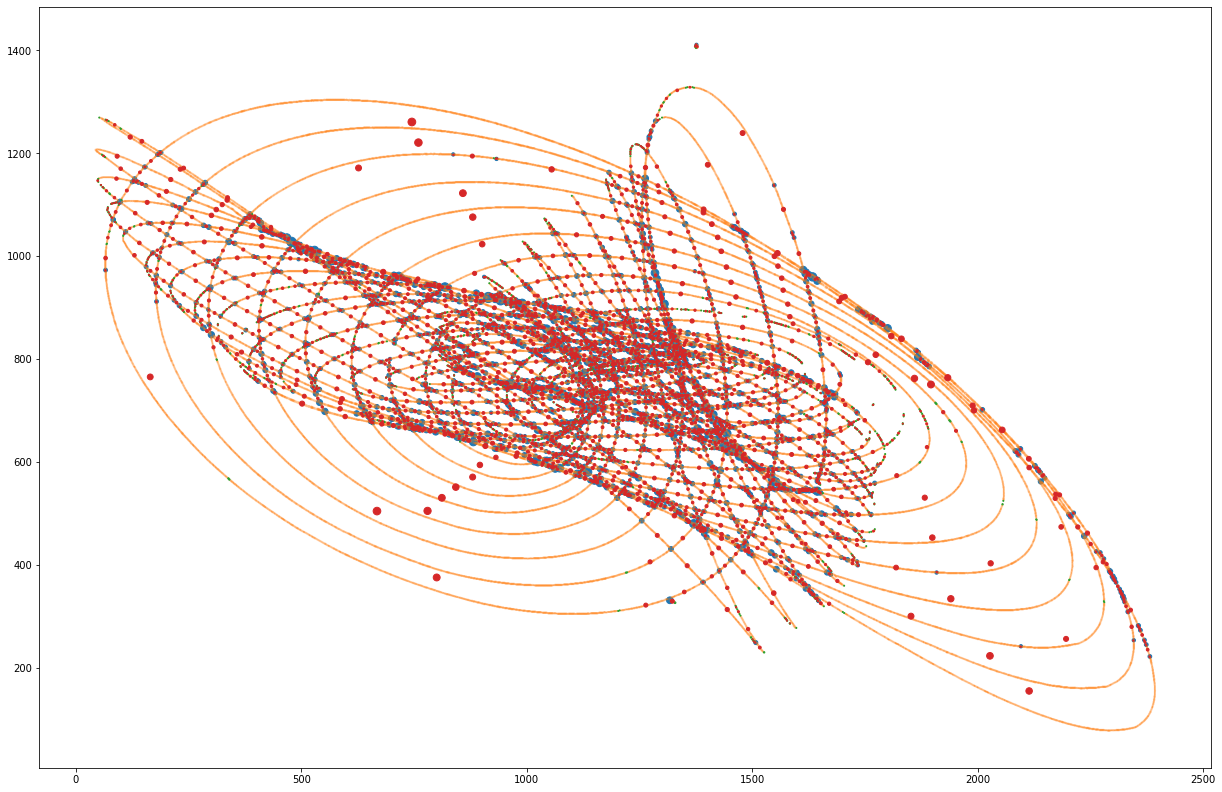

In [91]:
fig, ax = plt.subplots(figsize=(21,14))
scat=ax.scatter(newnh[:,0][newnh[:,3]>2],
         newnh[:,1][newnh[:,3]>2])
scat2=ax.scatter(newnh[:,0][newnh[:,3]==2],
         newnh[:,1][newnh[:,3]==2],alpha=0.2)
scat3=ax.scatter(newnh[:,0][newnh[:,3]==1],
         newnh[:,1][newnh[:,3]==1])
scat4=ax.scatter(pipeweight[:,0],
         pipeweight[:,1])
scat4.set_sizes(np.sqrt(pipeweight[:,2]))
scat3.set_sizes(np.sqrt(newnh[:,2][newnh[:,3]==1]))
scat2.set_sizes(np.sqrt(newnh[:,2][newnh[:,3]==2]))
scat.set_sizes(np.sqrt(newnh[:,2][newnh[:,3]>2])*5)#nnp[:,2]**2/5000)

In [5]:
newnh2=newnh[newnh[:,4]!=-1,:]

(-49.80281618023554, 2497.802816180236, 162.04566382844527, 1469.9543361715546)

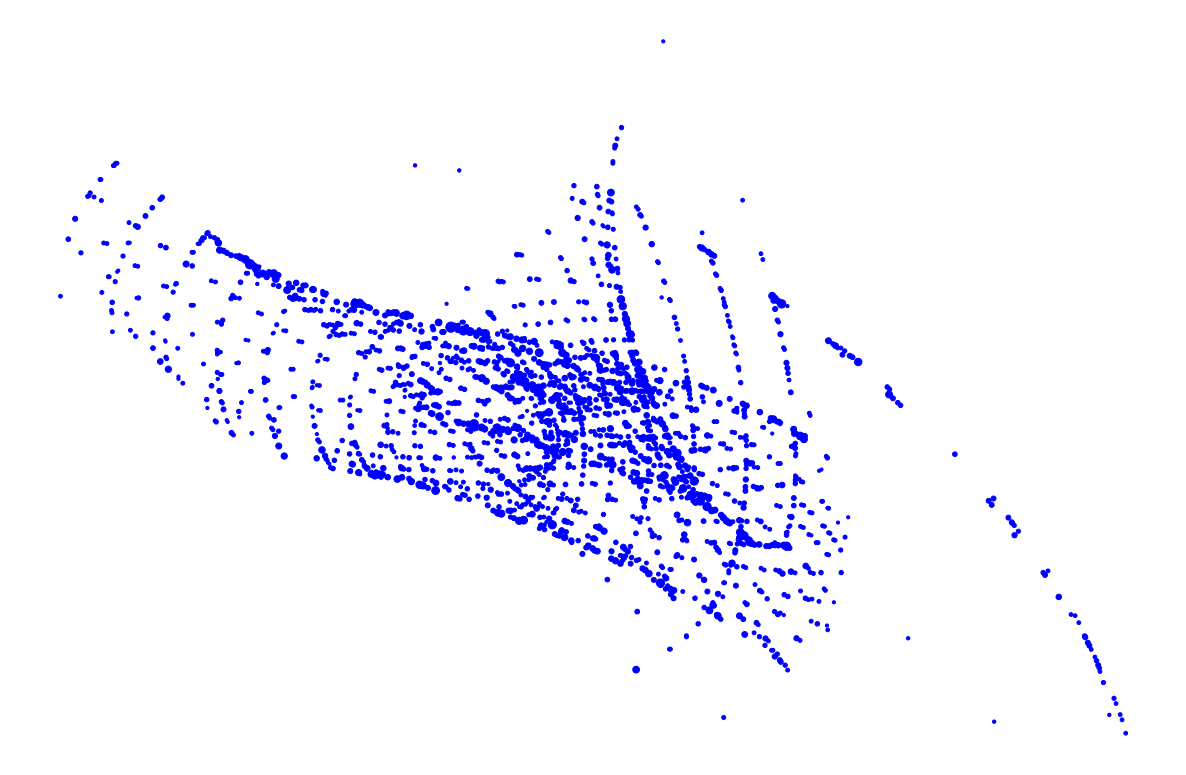

In [6]:
#pipeweight2=pipeweight[pipeweight[:,2]>40]
#newnh2=newnh[newnh[:,2]>8]
fig, ax = plt.subplots(figsize=(21,14))
scat=ax.scatter(newnh2[:,0][newnh2[:,3]>2],
         newnh2[:,1][newnh2[:,3]>2],c='b')
#scat2=ax.scatter(newnh2[:,0][newnh2[:,3]==2],
#         newnh2[:,1][newnh2[:,3]==2],alpha=0.2)
#scat3=ax.scatter(newnh2[:,0][newnh2[:,3]==1],
#         newnh2[:,1][newnh2[:,3]==1],c='g')
#scat4=ax.scatter(pipeweight2[:,0],
#         pipeweight2[:,1],c='r')
#scat4.set_sizes(np.sqrt(pipeweight2[:,2]))
#scat3.set_sizes(np.sqrt(newnh2[:,2][newnh2[:,3]==1]))
#scat2.set_sizes(np.sqrt(newnh2[:,2][newnh2[:,3]==2]))
scat.set_sizes(np.sqrt(newnh2[:,2][newnh2[:,3]>2])*5)#nnp[:,2]**2/5000)
plt.axis('off')
#plt.savefig('BlauSchnittpunkte_RotLinienschwerpunkte.png',format='png',dpi=400)

In [ ]:
fig, ax = plt.subplots(figsize=(21,14))
count=0

ax.scatter(newnh[:,0],newnh[:,1],s=0.1,c='k')

        #sc.set_sizes(np.sqrt(newnh[pipes[i],2]))
plt.axis('off')
plt.savefig('Original.png',format='png',dpi=400)

(-73.47500000000001, 2510.975, 15.024999999999999, 1389.475)

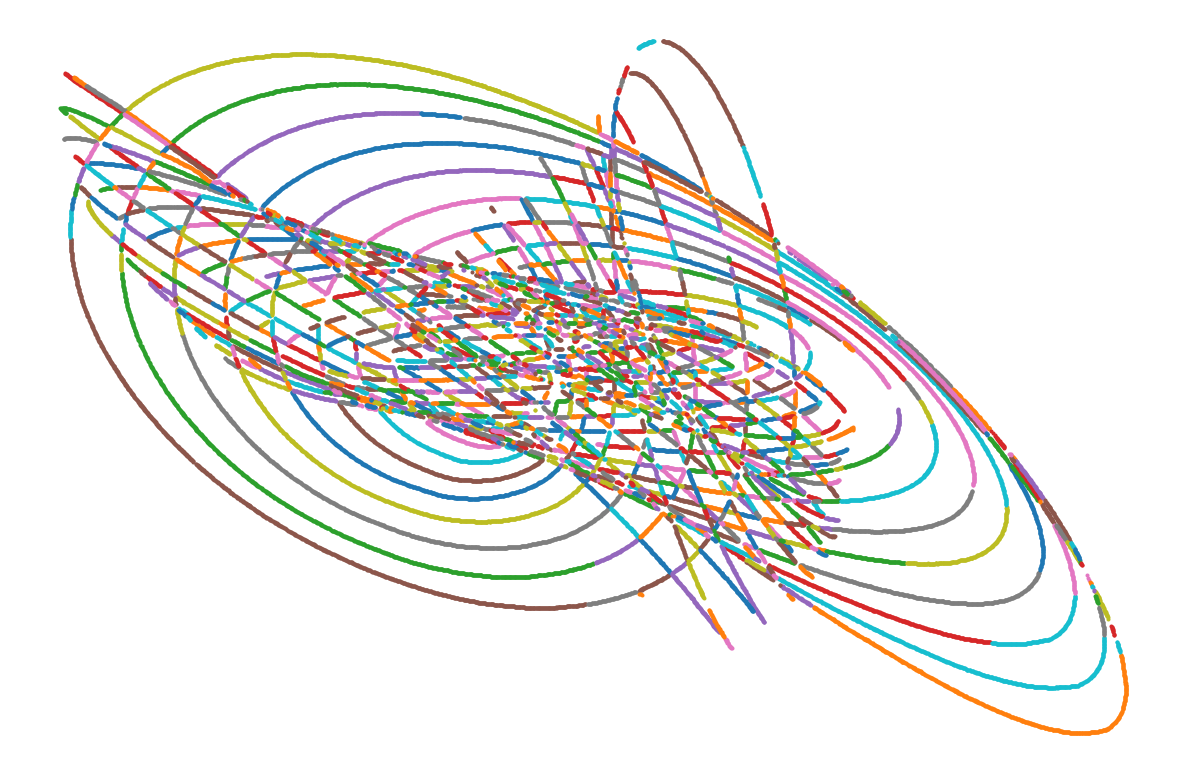

In [90]:
fig, ax = plt.subplots(figsize=(21,14))
count=0
for i in pipes:
    if pipeweight[count,2]>30:
        plt.plot(newnh[pipes[i],0],newnh[pipes[i],1],'.')
    count+=1
        #sc.set_sizes(np.sqrt(newnh[pipes[i],2]))
plt.axis('off')
#plt.savefig('GleicheFarbeBisLinienSichSchneiden.png',format='png',dpi=400)

In [ ]:
len(pipes)

In [ ]:
a=0
for i in range(len(pipes)):
    if i not in pipes:
        print(a)
        a+=1

In [ ]:
len(pipeweight)

In [ ]:
len(pipeweight2),len(newnh2)

In [ ]:
newnh2=newnh[newnh[:,2]>8]

In [ ]:
fig, ax = plt.subplots(figsize=(21,14))
scat=ax.scatter(newnh2[:,0][newnh2[:,3]>2],
         newnh2[:,1][newnh2[:,3]>2])
plt.axis('off')
plt.savefig('NurSchnittpunkteZwischenLinien.png',format='png',dpi=400)

In [ ]:
con=nx.connected_components(newg)
conn=[]
for i in con:
    conn.append(i)

In [ ]:
conn=[]
for i in con:
    conn.append(i)

In [ ]:
len(conn)

In [ ]:
len(nei)

In [ ]:
newimg=np.zeros(bimg.shape)
flatsp=[]


for i in range(len(newsp)):
    for j in range(len(newsp[i])):
        flatsp.append(newsp[i][j])

for i in range(len(flatsp)):
    if i in cset:
        value=5
    elif i in sset:
        value=1
    elif i in eset:
        value=2
    else:
        ind=np.where(newpipes[:,0]==i)[0]
        value=3+2*newpipes[ind,2]/np.max(newpipes[ind,2])
    
    newimg[flatsp[i][0],flatsp[i][1]]=value
    


In [ ]:
xma=[]
xmi=[]
yma=[]
ymi=[]
for i in range(len(flatsp)):
    xma.append(np.max(flatsp[i][0]))
    yma.append(np.max(flatsp[i][1]))
    xmi.append(np.min(flatsp[i][0]))
    ymi.append(np.min(flatsp[i][1]))
xmin=np.min(xmi)
ymin=np.min(ymi)
xmax=np.max(xma)
ymax=np.max(yma)

In [ ]:
print([xmin,xmax,ymin,ymax])

In [ ]:
print([xmax-xmin,ymax-ymin])

In [ ]:
print([xmax-xmin,ymax-ymin])

In [ ]:
(xmax-xmin)*(ymax-ymin)

In [ ]:
adj=nx.adjacency_matrix(newg)

In [ ]:
tm=adj.todense()

In [ ]:
start=np.ones(len(tm))

In [ ]:
np.dot(tm,start)

In [ ]:
from sys import getsizeof

In [ ]:
find(adj[:,0])

In [ ]:
plt.figure(figsize=[19,11])
plt.imshow(newimg,cmap='prism')
plt.savefig('conn6.png',format='png',dpi=400)

In [ ]:
nnp[:,3]

In [ ]:
len(np.unique(nnp[:,1]))

In [ ]:
fig, ax = plt.subplots(figsize=(21,14))
scat=ax.scatter(flatnh[nnp[:,0],0],
         flatnh[nnp[:,0],1])
scat.set_sizes(nnp[:,2]*0+0.1)#nnp[:,2]**2/5000)

In [ ]:
fig, ax = plt.subplots(figsize=(21,14))
#ax.axes(frameon=False)
scat=ax.scatter(flatnh[newcrossings[:,0],0],
         flatnh[newcrossings[:,0],1])
scat.set_sizes(newcrossings[:,1]+1)

In [ ]:
fig, ax = plt.subplots()

#ax.set_xlim(( 0, 2))
#ax.set_ylim((-2, 2))


x = np.linspace(0, 2, 1000)
y = np.sin(2 * np.pi * (x - 0.01 ))

scat=ax.scatter(flatnh[newcrossings[:,0],0],
         flatnh[newcrossings[:,0],1])

#scat = ax.scatter(x, y)
#scat2 = ax.scatter(y, x)
ts=np.zeros([len(x),2])
ts[:,0]=x
ts[:,1]=x**2


ms=0.1
def update(i):
    global ts
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    #ms+=0.5
    #line.set_data(x, y)
    #scat.s
    #scat.set_sizes(np.abs(y))
    ts=ts-0.1
    scat.set_offsets(ts)
    #return (line)

anim = FuncAnimation(fig, update, 
                               frames=100, interval=20 )

In [ ]:
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))


x = np.linspace(0, 2, 1000)
y = np.sin(2 * np.pi * (x - 0.01 ))


scat = ax.scatter(x, y)
scat2 = ax.scatter(y, x)
ts=np.zeros([len(x),2])
ts[:,0]=x
ts[:,1]=x**2


ms=0.1
def update(i):
    global ts
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    #ms+=0.5
    #line.set_data(x, y)
    #scat.s
    #scat.set_sizes(np.abs(y))
    ts=ts-0.1
    scat.set_offsets(ts)
    #return (line)

anim = FuncAnimation(fig, update, 
                               frames=100, interval=20 )

In [ ]:
HTML(anim.to_jshtml())

In [ ]:
x=np.where(gray<threshold)[0]
y=np.where(gray<threshold)[1]
plt.scatter(x,y,s=0.1)

In [ ]:
plt.imshow(newimg)
plt.colorbar()

In [ ]:
newimg[flatsp[9][0],

In [ ]:
newimg

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.animation as animation
from matplotlib import animation, rc
from IPython.display import HTML

fig = plt.figure()
test=np.zeros([400,100,100])
for i in range(400):
    test[i]=np.random.randint(0,10,[100,100])#test[i][i,:]+1
    #test[i][i:2*i,:]=test[i][i:2*i,:]+1

#test=np.zeros([40,100,100])
#for i in range(40):
#    test[i][i:2*i,:]=test[i][i:2*i,:]+1
    
def f(test):
    return test

im = plt.imshow(test[0], animated=True)

ind=0
def updatefig(*args):
    global ind
    im.set_array(test[ind])
    ind+=1
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=50,frames=360,blit=True)
#plt.show()


In [ ]:
HTML(ani.to_jshtml())

In [ ]:
import matplotlib
import numpy as np
a=np.random.randint(0,10,[100,100])

In [ ]:
#matplotlib.use("Agg")
from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib.animation import PillowWriter

metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = PillowWriter(fps=5, metadata=metadata)


test=np.zeros([40,100,100])
for i in range(40):
    test[i]=np.random.randint(0,10,[100,100])


fig = plt.figure(figsize=[19,11])
plt.axis('off')

im = plt.imshow(test[0])
ind=0
with writer.saving(fig, "writer_test.gif", 100):
    for i in range(40):
        updatefig()
        writer.grab_frame()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

fig = plt.figure()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

im = plt.imshow(f(x, y), animated=True)


def updatefig(*args):
    global x, y
    x += np.pi / 15.
    y += np.pi / 20.
    im.set_array(f(x, y))
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=50, blit=True)
#plt.show()


In [ ]:
HTML(ani.to_jshtml())

In [ ]:
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)



def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, 
                               blit=True)

In [ ]:
HTML(anim.to_jshtml())

In [ ]:
"""
===============
Rain simulation
===============

Simulates rain drops on a surface by animating the scale and opacity
of 50 scatter points.

Author: Nicolas P. Rougier
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


# Create new Figure and an Axes which fills it.
fig = plt.figure(figsize=(7, 7))
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim(0, 1), ax.set_xticks([])
ax.set_ylim(0, 1), ax.set_yticks([])

# Create rain data
n_drops = 50
rain_drops = np.zeros(n_drops, dtype=[('position', float, 2),
                                      ('size',     float, 1),
                                      ('growth',   float, 1),
                                      ('color',    float, 4)])

# Initialize the raindrops in random positions and with
# random growth rates.
rain_drops['position'] = np.random.uniform(0, 1, (n_drops, 2))
rain_drops['growth'] = np.random.uniform(50, 200, n_drops)

# Construct the scatter which we will update during animation
# as the raindrops develop.
scat = ax.scatter(rain_drops['position'][:, 0], rain_drops['position'][:, 1],
                  s=rain_drops['size'], lw=0.5, edgecolors=rain_drops['color'],
                  facecolors='none')


def update(frame_number):
    # Get an index which we can use to re-spawn the oldest raindrop.
    current_index = frame_number % n_drops

    # Make all colors more transparent as time progresses.
    rain_drops['color'][:, 3] -= 1.0/len(rain_drops)
    rain_drops['color'][:, 3] = np.clip(rain_drops['color'][:, 3], 0, 1)

    # Make all circles bigger.
    rain_drops['size'] += rain_drops['growth']

    # Pick a new position for oldest rain drop, resetting its size,
    # color and growth factor.
    rain_drops['position'][current_index] = np.random.uniform(0, 1, 2)
    rain_drops['size'][current_index] = 5
    rain_drops['color'][current_index] = (0, 0, 0, 1)
    rain_drops['growth'][current_index] = np.random.uniform(50, 200)

    # Update the scatter collection, with the new colors, sizes and positions.
    scat.set_edgecolors(rain_drops['color'])
    scat.set_sizes(rain_drops['size'])
    scat.set_offsets(rain_drops['position'])


# Construct the animation, using the update function as the animation
# director.
animation = FuncAnimation(fig, update, interval=10,frames=1000)
plt.show()


In [ ]:
HTML(animation.to_jshtml())

In [ ]:
threshold=0.5

In [ ]:
filename='variables.out'
my_shelf = shelve.open(filename,'n') # 'n' for new

my_shelf['newsp']=newsp
my_shelf['ups']=ups
my_shelf['nh']=nh
my_shelf['nc']=nc
my_shelf['flatnhc']=flatnhc
my_shelf['flatnh']=flatnh
my_shelf['neighbourlist']=neighbourlist

my_shelf['pipes']=pipes
my_shelf['ends']=ends
my_shelf['singles']=singles
my_shelf['cross']=cross

my_shelf['g']=g
my_shelf['S']=S


#Save everything
'''
for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and 
        #imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
'''
my_shelf.close()


In [ ]:
lev=5
retspiral=newsp
for i in range(len(retspiral[lev])):
    plt.plot(retspiral[lev][i][0],retspiral[lev][i][1])
plt.xlim([1275,1350])
plt.ylim([1500,1550])
plt.scatter(x,y,s=0.1)


In [ ]:
plt.scatter(x,y,s=0.1)

In [ ]:
newsp[2][0][0,:]

In [ ]:
newsp[2][0][1,:]

In [ ]:
bimg[newsp[3][0][0],newsp[3][0][1]]

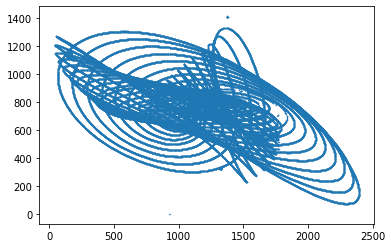

In [8]:
plt.plot(newsp[3][0][0,:],newsp[3][0][1,:],'o')
threshold=0.5
x=np.where(gray<threshold)[0]
y=np.where(gray<threshold)[1]
plt.scatter(x,y,s=0.1)

#plt.xlim([790,810])
#plt.ylim([2050,2150])
#plt.xlim([1860,1865])
#plt.ylim([1208,1212])

(1510, 1550)

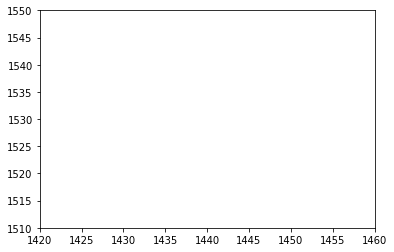

In [7]:
threshold=0.5
x=np.where(gray<threshold)[0]
y=np.where(gray<threshold)[1]
plt.scatter(x,y,s=0.1)
#plt.xlim([1400,1500])
#plt.ylim([1500,1550])
for i in range(8):
    plt.plot(nh[i][:,0],nh[i][:,1],'s',markersize=i*5+3)

plt.scatter(x,y,s=0.1)
plt.xlim([1420,1460])
plt.ylim([1510,1550])

In [ ]:
plt.figure(figsize=[19,11])
for i in range(15):
    plt.plot(nh[i][:,0],nh[i][:,1],'s',markersize=i*0.2+0.1)
plt.savefig('linewidth_color2.png',format='png',dpi=400)

In [ ]:
plt.plot(nh[0][:,0],nh[0][:,1],'.')

In [11]:
x

array([  43,   43,   44, ..., 2393, 2393, 2394])

(1510, 1550)

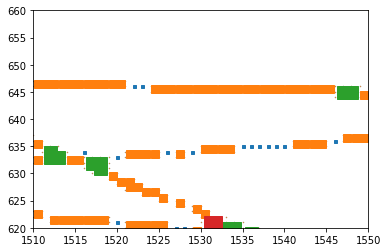

In [13]:
threshold=0.5
x=np.where(gray<threshold)[0]
y=np.where(gray<threshold)[1]
plt.scatter(x,y,s=0.1)
#plt.xlim([1400,1500])
#plt.ylim([1500,1550])
for i in range(8):
    plt.plot(nh[i][:,0],nh[i][:,1],'s',markersize=i*5+3)

plt.scatter(x,y,s=0.1)
plt.ylim([620,660])
plt.xlim([1510,1550])

(1510, 1550)

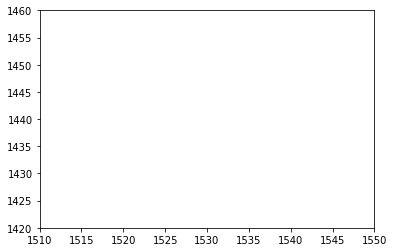

In [10]:
plt.scatter(x,y,s=0.8)
plt.ylim([1420,1460])
plt.xlim([1510,1550])

In [ ]:
len(nh)